# dp100_22 モデルの監視

Application Insightsは、Azureにおけるアプリケーションパフォーマンス管理サービスであり、  
これを使用することでアプリケーションからテレメトリデータを取り込んで、格納及び分析することができる。

## Application Insightsを有効にする

AzureMLサービスからApplication Insightsにテレメトリをログするには、  
ワークスペースに関連付けられたApplication Insightsリソースを用意する必要がある。  
また、それを使用してテレメトリをログするようにサービスを構成する必要がある。

### Application Insightsとワークスペースを関連付ける

ワークスペース作成時には、それに関連付けるApplication Insightsリソースを選択できる。  
既存のApplication Insightsリソースを選択しない場合、利用しているワークスペースと同じリソースグループ内に新しいものが作成される。

Application Insightsリソースを確認するにはポータルの概要ページを表示するか、  
以下のコードのように**Workspace**オブジェクトの**get_details()**メソッドを利用する。

```
from azureml.core import Workspace

ws = Workspace.from_config()
ws.get_details()['applicationInsights']
```

### サービスに対してApplication Insightsを有効にする

新しいリアルタイムサービスをデプロイする場合は、以下の例のようにそのサービスのデプロイ構成で  
Application Insightsを有効にすることができる。

```
dep_config = AciWebservice.deploy_configuration(cpu_cores = 1,
                                                memory_gb = 1,
                                                enable_app_insights=True)
```

既にデプロイされているサービスに対してApplication Insightsを有効にしたい場合は、AKSベースのサービスのデプロイ構成を変更できる。  
また、以下のようにSDKを使用して任意のWebサービスを更新することもできる。

```
service = ws.webservices['my-svc']
service.update(enable_app_insights=True)
```

## テレメトリを取り込んで表示する

Application Insightsを有効にすると、標準出力及びエラーログに書き込まれた情報が自動的に取り込まれる。  
また、クエリ機能を使用してこれらのログ内のデータを表示できるようになる。

### ログデータを書き込む

Application Insights用にテレメトリデータを取り込むために、次の例に示すように、  
ご利用のサービスのスコアリングスクリプト内で`print`ステートメントを使用して、標準出力ログに任意の値を書き込むことができる。

```
def init():
    global model
    model = joblib.load(Model.get_model_path('my_model'))
def run(raw_data):
    data = json.loads(raw_data)['data']
    predictions = model.predict(data)
    log_txt = 'Data:' + str(data) + ' - Predictions:' + str(predictions)
    print(log_txt)
    return predictions.tolist()
```

AzureMLによって、作成した出力に対応する*カスタムディメンション*がApplication Insightsデータモデル内に作成される。

### Application Insightsのログに対してクエリを実行する

取り込んだログを分析にするには、Log Analyticsクエリインターフェイスを使用する。このインターフェイスはSQLに似たクエリ構文がサポートされている。  
これを使用することで、AzureMLによって作成されたカスタムディメンションなど、ログされたデータからフィールドを抽出できる。

たとえば、次のクエリを実行すると*STDOUT*の**message**フィールド値(データが標準出力ログ内にあることを示す)と  
*my-svc*の**customDimensious.["Service Name"]**フィールド値を含むログトレースから、**timestamp**および  
**customDimensious.Content**フィールドが返される。

```
traces
|where message == "STDOUT"
  and customDimensions.["Service Name"] = "my-svc"
| project  timestamp, customDimensions.Content
```

## 演習　モデルを監視する

Application Insightsを使用して、モデルのサービスエンドポイントのアクティビティを監視することができる。

### ワークスペースに接続する

In [1]:
from azureml.core import Workspace

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to work with', ws.name)

Ready to work with 20210613


### デプロイの準備

1. データセットの作成と登録
2. データセットを使ってモデル学習
3. モデルの登録

In [2]:
from azureml.core import Experiment
from azureml.core import Model
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from azureml.core import Dataset

# Upload data files to the default datastore
default_ds = ws.get_default_datastore()
default_ds.upload_files(files=['./data/diabetes.csv', './data/diabetes2.csv'],
                       target_path='diabetes-data/',
                       overwrite=True,
                       show_progress=True)

#Create a tabular dataset from the path on the datastore
print('Creating dataset...')
data_set = Dataset.Tabular.from_delimited_files(path=(default_ds, 'diabetes-data/*.csv'))

# Register the tabular dataset
print('Registering dataset...')
try:
    data_set = data_set.register(workspace=ws, 
                               name='diabetes dataset',
                               description='diabetes data',
                               tags = {'format':'CSV'},
                               create_new_version=True)
except Exception as ex:
    print(ex)

# Create an Azure ML experiment in your workspace
experiment = Experiment(workspace=ws, name='mslearn-train-diabetes')
run = experiment.start_logging()
print("Starting experiment:", experiment.name)

# load the diabetes dataset
print("Loading Data...")
diabetes = data_set.to_pandas_dataframe()

# Separate features and labels
X, y = diabetes[['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']].values, diabetes['Diabetic'].values

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Train a decision tree model
print('Training a decision tree model')
model = DecisionTreeClassifier().fit(X_train, y_train)

# calculate accuracy
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
print('Accuracy:', acc)
run.log('Accuracy', np.float(acc))

# calculate AUC
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))
run.log('AUC', np.float(auc))

# Save the trained model
model_file = 'diabetes_model.pkl'
joblib.dump(value=model, filename=model_file)
run.upload_file(name = 'outputs/' + model_file, path_or_stream = './' + model_file)

# Complete the run
run.complete()

# Register the model
print('Registering model...')
run.register_model(model_path='outputs/diabetes_model.pkl', model_name='diabetes_model',
                   tags={'Training context':'Inline Training'},
                   properties={'AUC': run.get_metrics()['AUC'], 'Accuracy': run.get_metrics()['Accuracy']})

# Get the registered model
model = ws.models['diabetes_model']

print('Model trained and registered.')

Uploading an estimated of 2 files
Uploading ./data/diabetes.csv
Uploaded ./data/diabetes.csv, 1 files out of an estimated total of 2
Uploading ./data/diabetes2.csv
Uploaded ./data/diabetes2.csv, 2 files out of an estimated total of 2
Uploaded 2 files
Creating dataset...
Registering dataset...
Starting experiment: mslearn-train-diabetes
Loading Data...
Training a decision tree model
Accuracy: 0.896
AUC: 0.8804451597547693
Registering model...
Model trained and registered.


### モデルをWebサービスとしてデプロイ

デプロイ用のフォルダ、スクリプトの作成。

In [3]:
import os

folder_name = 'diabetes_service'

# Create a folder for the web service files
experiment_folder = './' + folder_name
os.makedirs(experiment_folder, exist_ok=True)

print(folder_name, 'folder created.')

# Set path for scoring script
script_file = os.path.join(experiment_folder,"score_diabetes.py")

diabetes_service folder created.


In [4]:
%%writefile $script_file
import json
import joblib
import numpy as np
from azureml.core.model import Model

# Called when the service is loaded
def init():
    global model
    # Get the path to the deployed model file and load it
    model_path = Model.get_model_path('diabetes_model')
    model = joblib.load(model_path)

# Called when a request is received
def run(raw_data):
    # Get the input data as a numpy array
    data = json.loads(raw_data)['data']
    np_data = np.array(data)
    # Get a prediction from the model
    predictions = model.predict(np_data)
    
    # print the data and predictions (so they'll be logged!)
    log_text = 'Data:' + str(data) + ' - Predictions:' + str(predictions)
    print(log_text)
    
    # Get the corresponding classname for each prediction (0 or 1)
    classnames = ['not-diabetic', 'diabetic']
    predicted_classes = []
    for prediction in predictions:
        predicted_classes.append(classnames[prediction])
    # Return the predictions as JSON
    return json.dumps(predicted_classes)

Overwriting ./diabetes_service/score_diabetes.py


サービス環境用のCondaの設定ファイルを作成する。

In [5]:
from azureml.core.conda_dependencies import CondaDependencies 

# Add the dependencies for our model (AzureML defaults is already included)
myenv = CondaDependencies()
myenv.add_conda_package("scikit-learn")

# Save the environment config as a .yml file
env_file = folder_name + "/diabetes_env.yml"
with open(env_file,"w") as f:
    f.write(myenv.serialize_to_string())
print("Saved dependency info in", env_file)

# Print the .yml file
with open(env_file,"r") as f:
    print(f.read())

Saved dependency info in diabetes_service/diabetes_env.yml
# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
    # Required packages for AzureML execution, history, and data preparation.
  - azureml-defaults

- scikit-learn
channels:
- anaconda
- conda-forge



サービスをデプロイする。

In [6]:
from azureml.core.webservice import AciWebservice, Webservice
from azureml.core.model import Model
from azureml.core.model import InferenceConfig

# Configure the scoring environment
inference_config = InferenceConfig(runtime= "python",
                                   entry_script=script_file,
                                   conda_file=env_file)

service_name = "diabetes-service-app-insights"
deployment_config = AciWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 1)
aci_service = Model.deploy(workspace=ws,
                           name= service_name,
                           models= [model],
                           inference_config= inference_config,
                           deployment_config=deployment_config)
aci_service.wait_for_deployment(show_output = True)
print(aci_service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-06-16 16:04:26+00:00 Creating Container Registry if not exists.
2021-06-16 16:04:27+00:00 Registering the environment.
2021-06-16 16:04:28+00:00 Use the existing image.
2021-06-16 16:04:28+00:00 Generating deployment configuration.
2021-06-16 16:04:29+00:00 Submitting deployment to compute.
2021-06-16 16:04:32+00:00 Checking the status of deployment diabetes-service-app-insights..
2021-06-16 16:06:22+00:00 Checking the status of inference endpoint diabetes-service-app-insights.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


### Application Insightsの有効化

サービスのApplication Insightsを有効化する。

In [7]:
# Enable AppInsights
aci_service.update(enable_app_insights=True)
print('AppInsights enabled!')

AppInsights enabled!


### Webサービスの利用

クライアントアプリケーションからサービスを利用することができる。  
これらのアプリケーションがリクエストを送信するためのURLを決定する。

In [8]:
endpoint = aci_service.scoring_uri
print(endpoint)

http://0a39c432-aac9-4639-a276-3702c8203597.westus2.azurecontainer.io/score


実際にリクエストを送ってみる。

In [11]:
import requests
import json

# Create new data for inferencing
x_new = [[2,180,74,24,21,23.9091702,1.488172308,22],
         [0,148,58,11,179,39.19207553,0.160829008,45]]

# Convert the array to a serializable list in a JSON document
input_json = json.dumps({"data": x_new})

# Set the content type
headers = { 'Content-Type':'application/json' }

# Get the predictions
predictions = requests.post(endpoint, input_json, headers = headers)
print(predictions.status_code)
if predictions.status_code == 200:
    predicted_classes = json.loads(predictions.json())
    for i in range(len(x_new)):
        print ("Patient {}".format(x_new[i]), predicted_classes[i] )

200
Patient [2, 180, 74, 24, 21, 23.9091702, 1.488172308, 22] diabetic
Patient [0, 148, 58, 11, 179, 39.19207553, 0.160829008, 45] not-diabetic


ワークスペースの概要よりApplication Insightsへ移動し、以下のクエリを発行すると、結果が返ってくる。

```
 traces
 |where  message == "STDOUT"
   and customDimensions.["Service Name"] == "diabetes-service-app-insights"
 |project timestamp, customDimensions.Content
```

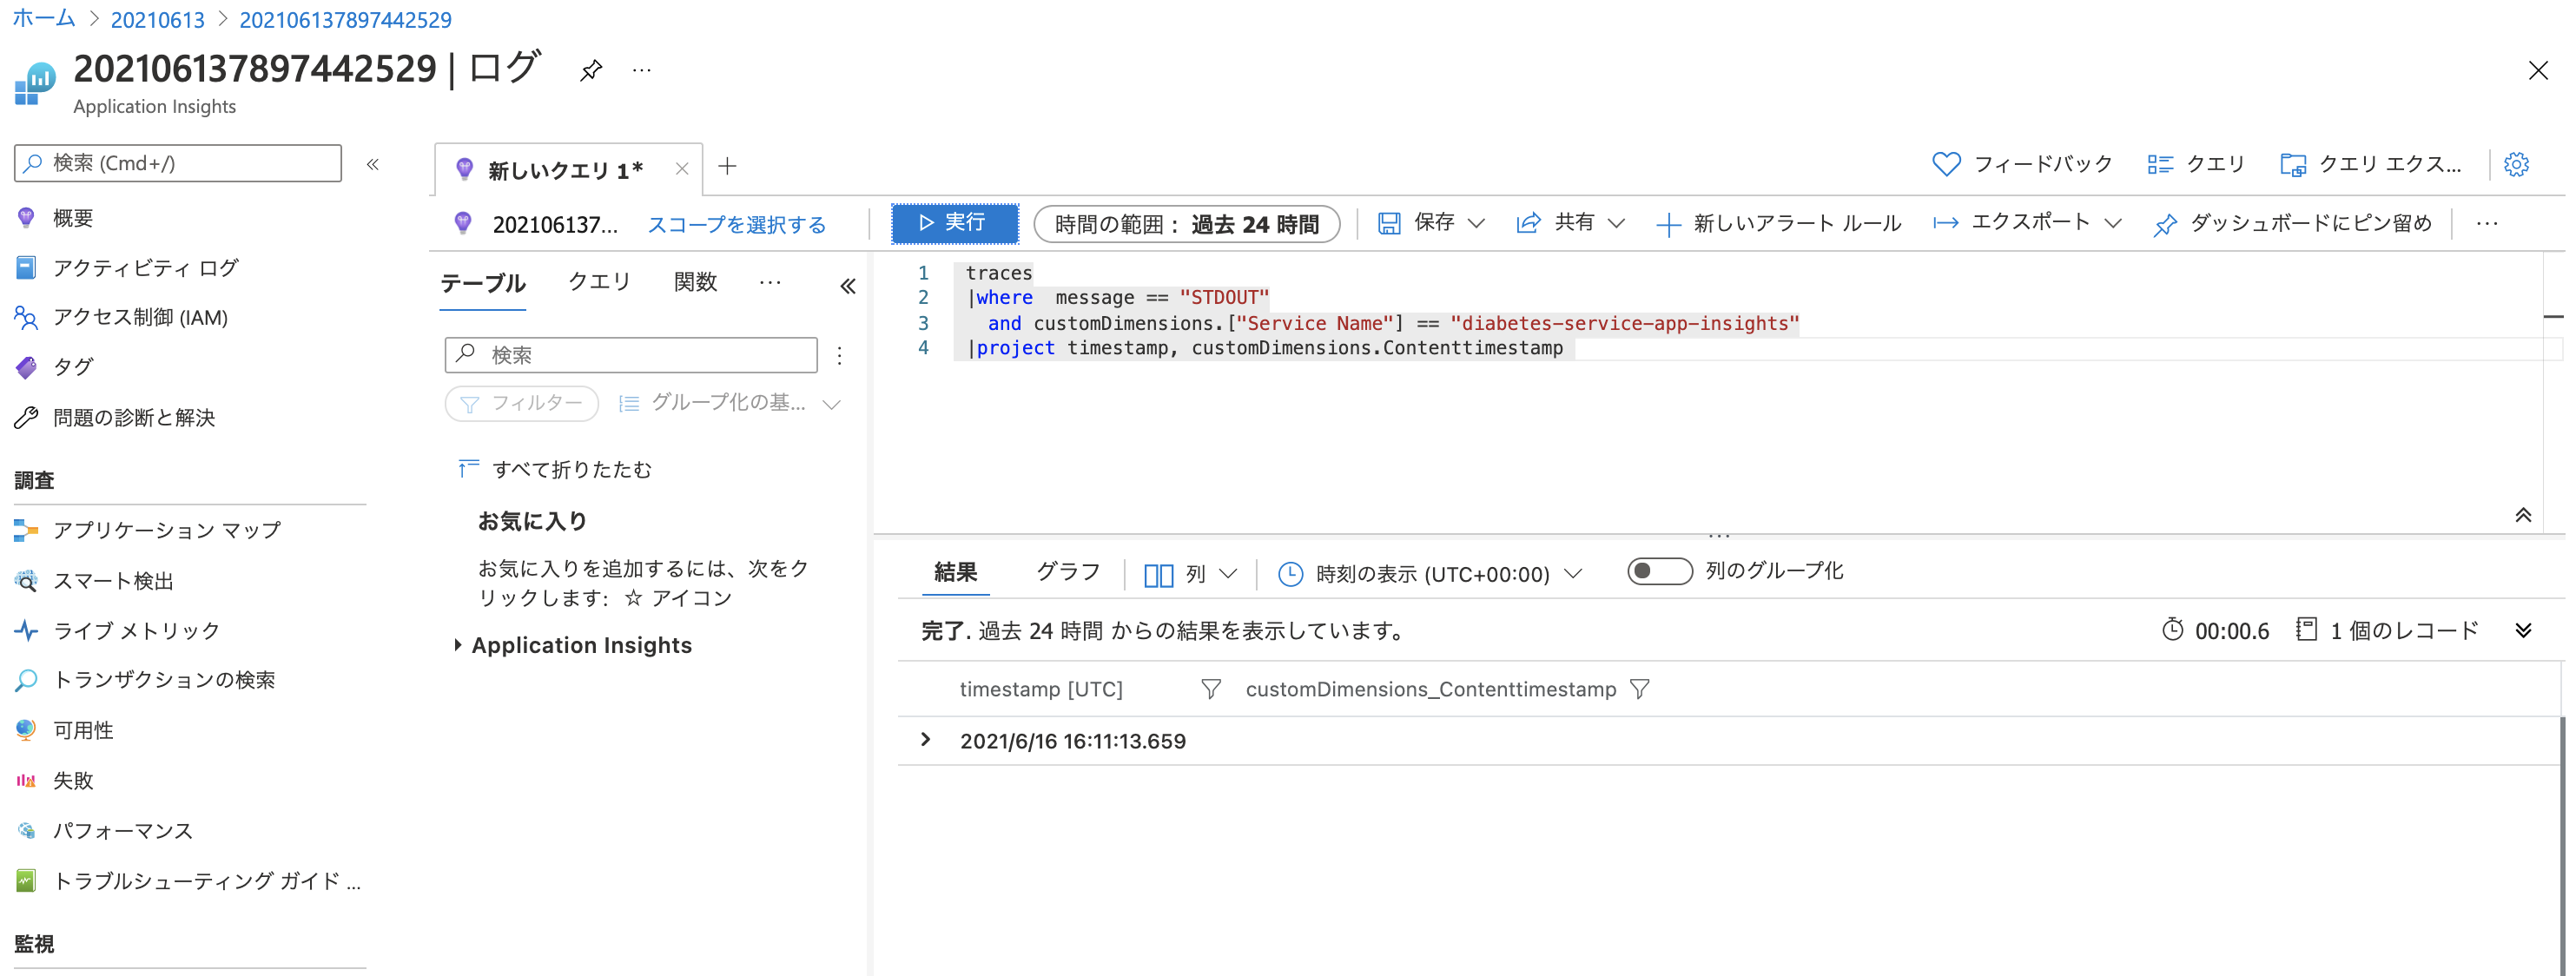

### サービスの削除

In [12]:
try:
    aci_service.delete()
    print('Service deleted.')
except Exception as ex:
    print(ex.message)

Service deleted.


## 知識チェック

1. あなたは Azure Kubernetes Service (AKS) クラスターに、モデルをリアルタイムの推論サービスとしてデプロイしました。  
このサービスのテレメトリを取り込んで分析するには、何を行う必要がありますか?

    - モデルを ACI サービスとして再デプロイする。
    - Application Insights を有効にする。
    - AKS クラスターを Azure Machine Learning ワークスペースと同じリージョンに移動する。

2. あなたは推論サービスのテレメトリにカスタム情報を含め、それを Application Insights を使用して分析したいと考えています。  
サービスのエントリ スクリプト内で何を行う必要がありますか?

    - Run.log メソッドを使用して、カスタム メトリックをログする。
    - カスタム メトリックを ./outputs フォルダーに保存する。
    - print ステートメントを使用して、STDOUT ログにメトリックを書き込む。

↓解答

1. Application Insights を有効にする。

    - Application Insights を介したテレメトリ分析を有効にするには、  
    サービスに対して Application Insights を有効にする必要があります。


2. print ステートメントを使用して、STDOUT ログにメトリックを書き込む。

    - カスタム メトリックを含めるには、スコアリング スクリプトに print ステートメントを追加して、  
    カスタム情報が STDOUT ログに書き込まれるようにします。